In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from scipy.special import expit
import torch
from torch import nn, optim
import torch.nn.functional as F
from datasets.datasets import get_wine_dataloader, get_iris_dataloader, get_australian_dataloader, get_10x_73k_dataloader
from sklearn.manifold import TSNE

cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

## Wine

In [3]:
n_clusters = 3
batch_size = 89
dataloader, data_shape = get_wine_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 10
h2 = 30
latent_dim = 5

## Iris

In [2]:
n_clusters = 3
batch_size = 50
dataloader, data_shape = get_iris_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 3
h2 = 15
latent_dim = 2

## Australian

In [2]:
n_clusters = 2
batch_size = 69
dataloader, data_shape = get_australian_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 10
h2 = 30
latent_dim = 3

## 10x_73k

In [2]:
n_clusters = 8
batch_size = 256
dataloader, data_shape = get_10x_73k_dataloader(batch_size)
N = len(dataloader) * batch_size

h1 = 500
h2 = 1500
latent_dim = 10

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, n_features):
        super(Autoencoder, self).__init__()
        # Encoder Model
        self.encoder_model = nn.Sequential(
            nn.Linear(data_shape, h1, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h1),
            
            nn.Linear(h1, h2, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h2),
            
            nn.Linear(h2, latent_dim, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(latent_dim),
            
            #nn.Linear(h3, h4, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(h4),
        )
        
        # Clustering MLP
        self.cluster_MLP = nn.Sequential(
            #nn.Linear(latent_dim, h1, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(h1),
            
            nn.Linear(latent_dim, n_clusters, bias=True),
            nn.BatchNorm1d(n_clusters)
        )
        
        # Decoder Model
        self.decoder_model = nn.Sequential(
            #nn.Linear(h4, h3, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(h3),
            
            nn.Linear(latent_dim, h2, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h2),
            
            nn.Linear(h2, h1, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h1),
            
            nn.Linear(h1, data_shape, bias=True),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.encoder_model(x)
        x = self.decoder_model(x)
        return x

    def forward_softMax(self, x):
        x = self.encoder_model(x)
        x = self.cluster_MLP(x)
        x = F.softmax(x, dim=1)
        return x
    
    def encoder(self, x):
        x = self.encoder_model(x)
        return x
    
    def decoder(self, x):
        x = self.decoder_model(x)
        return x

autoencoder = Autoencoder(100)
autoencoder = autoencoder.to(device)

In [4]:
def soft_silhouette(X, soft_clustering, requires_distance_grad=False):
    # No grads at distances
    if requires_distance_grad: X = X.detach()
    distances = torch.cdist(X, X, p=2)
    alphas = torch.matmul(distances, soft_clustering).to(device)
    n_data, n_clusters = alphas.shape
    betas = torch.empty(alphas.shape).to(device)
    
    for i in range(n_data):
        for j in range(n_clusters):
            betas[i][j] = min([alphas[i][x] for x in range(alphas.shape[1]) if x!=j])
    
    # Calculate soft silhouette
    sc = torch.div(torch.sub(betas, alphas), torch.max(alphas, betas))
    s = torch.mean(torch.sum(torch.mul(soft_clustering, sc), dim=1))

    return s

def transform_clusters_to_labels(clusters, labels):
    # Get the data clusters based on max neuron
    clusters = torch.argmax(clusters, dim=1)
    clusters = clusters.cpu().detach().numpy()

    # Find the cluster ids (labels)
    c_ids = np.unique(clusters)
    labels = labels.cpu().data.numpy()

    # Dictionary to transform cluster label to real label
    dict_clusters_to_labels = dict()
    
    # For every cluster find the most frequent data label
    for c_id in c_ids:
        indexes_of_cluster_i = np.where(c_id == clusters)
        elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
        true_label_index = np.argmax(frequency)
        true_label = elements[true_label_index]
        dict_clusters_to_labels[c_id] = true_label

    # Change the cluster labels to real labels
    for i, element in enumerate(clusters):
        clusters[i] = dict_clusters_to_labels[element]

    return clusters

In [5]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
mse = nn.MSELoss()

for epoch in range(1000):
    for batch_index, (real_data, labels) in enumerate(dataloader):
        real_data = real_data.to(device)
        reconstruction = autoencoder.forward(real_data)
        loss = mse(real_data, reconstruction)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: {} Rec: {:.4f} ".format(epoch, loss))

Epoch: 0 Rec: 0.2011 
Epoch: 1 Rec: 0.1536 
Epoch: 2 Rec: 0.1229 
Epoch: 3 Rec: 0.1154 
Epoch: 4 Rec: 0.1056 
Epoch: 5 Rec: 0.1051 
Epoch: 6 Rec: 0.0984 
Epoch: 7 Rec: 0.0982 
Epoch: 8 Rec: 0.0947 
Epoch: 9 Rec: 0.0937 
Epoch: 10 Rec: 0.0887 
Epoch: 11 Rec: 0.0888 
Epoch: 12 Rec: 0.0876 
Epoch: 13 Rec: 0.0889 
Epoch: 14 Rec: 0.0886 
Epoch: 15 Rec: 0.0865 
Epoch: 16 Rec: 0.0866 
Epoch: 17 Rec: 0.0865 
Epoch: 18 Rec: 0.0858 
Epoch: 19 Rec: 0.0849 
Epoch: 20 Rec: 0.0846 
Epoch: 21 Rec: 0.0856 
Epoch: 22 Rec: 0.0864 
Epoch: 23 Rec: 0.0865 
Epoch: 24 Rec: 0.0845 
Epoch: 25 Rec: 0.0839 
Epoch: 26 Rec: 0.0890 
Epoch: 27 Rec: 0.0871 
Epoch: 28 Rec: 0.0888 
Epoch: 29 Rec: 0.0869 
Epoch: 30 Rec: 0.0860 
Epoch: 31 Rec: 0.0848 
Epoch: 32 Rec: 0.0857 
Epoch: 33 Rec: 0.0859 
Epoch: 34 Rec: 0.0847 
Epoch: 35 Rec: 0.0828 
Epoch: 36 Rec: 0.0821 
Epoch: 37 Rec: 0.0814 
Epoch: 38 Rec: 0.0813 
Epoch: 39 Rec: 0.0814 
Epoch: 40 Rec: 0.0815 
Epoch: 41 Rec: 0.0815 
Epoch: 42 Rec: 0.0815 
Epoch: 43 Rec: 0.0813

Epoch: 348 Rec: 0.0058 
Epoch: 349 Rec: 0.0058 
Epoch: 350 Rec: 0.0058 
Epoch: 351 Rec: 0.0058 
Epoch: 352 Rec: 0.0058 
Epoch: 353 Rec: 0.0058 
Epoch: 354 Rec: 0.0058 
Epoch: 355 Rec: 0.0058 
Epoch: 356 Rec: 0.0058 
Epoch: 357 Rec: 0.0058 
Epoch: 358 Rec: 0.0059 
Epoch: 359 Rec: 0.0058 
Epoch: 360 Rec: 0.0058 
Epoch: 361 Rec: 0.0058 
Epoch: 362 Rec: 0.0058 
Epoch: 363 Rec: 0.0058 
Epoch: 364 Rec: 0.0058 
Epoch: 365 Rec: 0.0058 
Epoch: 366 Rec: 0.0058 
Epoch: 367 Rec: 0.0058 
Epoch: 368 Rec: 0.0058 
Epoch: 369 Rec: 0.0059 
Epoch: 370 Rec: 0.0058 
Epoch: 371 Rec: 0.0058 
Epoch: 372 Rec: 0.0058 
Epoch: 373 Rec: 0.0058 
Epoch: 374 Rec: 0.0058 
Epoch: 375 Rec: 0.0059 
Epoch: 376 Rec: 0.0058 
Epoch: 377 Rec: 0.0058 
Epoch: 378 Rec: 0.0058 
Epoch: 379 Rec: 0.0059 
Epoch: 380 Rec: 0.0060 
Epoch: 381 Rec: 0.0059 
Epoch: 382 Rec: 0.0059 
Epoch: 383 Rec: 0.0059 
Epoch: 384 Rec: 0.0061 
Epoch: 385 Rec: 0.0059 
Epoch: 386 Rec: 0.0059 
Epoch: 387 Rec: 0.0059 
Epoch: 388 Rec: 0.0058 
Epoch: 389 Rec: 

Epoch: 694 Rec: 0.0060 
Epoch: 695 Rec: 0.0060 
Epoch: 696 Rec: 0.0059 
Epoch: 697 Rec: 0.0060 
Epoch: 698 Rec: 0.0060 
Epoch: 699 Rec: 0.0060 
Epoch: 700 Rec: 0.0059 
Epoch: 701 Rec: 0.0059 
Epoch: 702 Rec: 0.0059 
Epoch: 703 Rec: 0.0059 
Epoch: 704 Rec: 0.0059 
Epoch: 705 Rec: 0.0059 
Epoch: 706 Rec: 0.0059 
Epoch: 707 Rec: 0.0059 
Epoch: 708 Rec: 0.0059 
Epoch: 709 Rec: 0.0059 
Epoch: 710 Rec: 0.0059 
Epoch: 711 Rec: 0.0059 
Epoch: 712 Rec: 0.0059 
Epoch: 713 Rec: 0.0059 
Epoch: 714 Rec: 0.0059 
Epoch: 715 Rec: 0.0059 
Epoch: 716 Rec: 0.0059 
Epoch: 717 Rec: 0.0059 
Epoch: 718 Rec: 0.0059 
Epoch: 719 Rec: 0.0059 
Epoch: 720 Rec: 0.0059 
Epoch: 721 Rec: 0.0059 
Epoch: 722 Rec: 0.0059 
Epoch: 723 Rec: 0.0059 
Epoch: 724 Rec: 0.0059 
Epoch: 725 Rec: 0.0059 
Epoch: 726 Rec: 0.0059 
Epoch: 727 Rec: 0.0059 
Epoch: 728 Rec: 0.0059 
Epoch: 729 Rec: 0.0059 
Epoch: 730 Rec: 0.0059 
Epoch: 731 Rec: 0.0059 
Epoch: 732 Rec: 0.0059 
Epoch: 733 Rec: 0.0059 
Epoch: 734 Rec: 0.0059 
Epoch: 735 Rec: 

In [6]:
lamda = 100
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
mse = nn.MSELoss()

latent_data = np.zeros((N, latent_dim))
real_labels = np.zeros((N), dtype=np.int32)
predicted_labels = np.zeros((N), dtype=np.int32)

for epoch in range(200):
    sum_rec_loss = 0
    sum_soft_sihouette = 0
    for batch_index, (real_data, labels) in enumerate(dataloader):
        real_data = real_data.to(device)
        reconstruction = autoencoder.forward(real_data)
        soft_clustering = autoencoder.forward_softMax(real_data).to(device)
        code = autoencoder.encoder(real_data).to(device)
        s = soft_silhouette(code, soft_clustering, requires_distance_grad=True)
        rec = mse(reconstruction, real_data)
        loss = 1 - s + lamda * rec
        
        sum_rec_loss += rec.item()
        sum_soft_sihouette += s.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Selecting the nearest samples and save their priors
        lower = batch_index * batch_size
        upper = (batch_index + 1) * batch_size
        latent_data[lower:upper] = code.cpu().detach().numpy()
        real_labels[lower:upper] = labels.cpu().data.numpy()
        predicted_labels[lower:upper] = transform_clusters_to_labels(soft_clustering, labels)
    
    accuracy = accuracy_score(real_labels, predicted_labels)
    nmi = normalized_mutual_info_score(real_labels, predicted_labels)
    total_loss = sum_rec_loss + sum_soft_sihouette
    print("Epoch: {} L: {:.4f} Rec: {:.4f} Soft SIL: {:.2f} ACC: {:.2f} NMI: {:.2f} ".format(epoch, total_loss, sum_rec_loss, sum_soft_sihouette, accuracy, nmi))

Epoch: 0 L: 0.6342 Rec: 0.0262 Soft SIL: 0.61 ACC: 0.87 NMI: 0.69 
Epoch: 1 L: 0.7356 Rec: 0.0307 Soft SIL: 0.70 ACC: 0.89 NMI: 0.73 
Epoch: 2 L: 0.7859 Rec: 0.0247 Soft SIL: 0.76 ACC: 0.89 NMI: 0.73 
Epoch: 3 L: 0.8260 Rec: 0.0233 Soft SIL: 0.80 ACC: 0.88 NMI: 0.72 
Epoch: 4 L: 0.8753 Rec: 0.0221 Soft SIL: 0.85 ACC: 0.86 NMI: 0.67 
Epoch: 5 L: 0.9247 Rec: 0.0223 Soft SIL: 0.90 ACC: 0.87 NMI: 0.68 
Epoch: 6 L: 0.9775 Rec: 0.0214 Soft SIL: 0.96 ACC: 0.86 NMI: 0.67 
Epoch: 7 L: 1.0433 Rec: 0.0215 Soft SIL: 1.02 ACC: 0.87 NMI: 0.68 
Epoch: 8 L: 1.0971 Rec: 0.0207 Soft SIL: 1.08 ACC: 0.87 NMI: 0.69 
Epoch: 9 L: 1.1393 Rec: 0.0204 Soft SIL: 1.12 ACC: 0.87 NMI: 0.71 
Epoch: 10 L: 1.1734 Rec: 0.0203 Soft SIL: 1.15 ACC: 0.87 NMI: 0.71 
Epoch: 11 L: 1.2011 Rec: 0.0201 Soft SIL: 1.18 ACC: 0.87 NMI: 0.71 
Epoch: 12 L: 1.2382 Rec: 0.0200 Soft SIL: 1.22 ACC: 0.87 NMI: 0.71 
Epoch: 13 L: 1.2824 Rec: 0.0197 Soft SIL: 1.26 ACC: 0.88 NMI: 0.71 
Epoch: 14 L: 1.3277 Rec: 0.0196 Soft SIL: 1.31 ACC: 0.89 N

Epoch: 122 L: 2.3806 Rec: 0.0186 Soft SIL: 2.36 ACC: 0.89 NMI: 0.74 
Epoch: 123 L: 2.4267 Rec: 0.0187 Soft SIL: 2.41 ACC: 0.89 NMI: 0.72 
Epoch: 124 L: 2.3764 Rec: 0.0187 Soft SIL: 2.36 ACC: 0.89 NMI: 0.74 
Epoch: 125 L: 2.4300 Rec: 0.0190 Soft SIL: 2.41 ACC: 0.89 NMI: 0.72 
Epoch: 126 L: 2.3668 Rec: 0.0189 Soft SIL: 2.35 ACC: 0.90 NMI: 0.75 
Epoch: 127 L: 2.3570 Rec: 0.0188 Soft SIL: 2.34 ACC: 0.89 NMI: 0.74 
Epoch: 128 L: 2.4129 Rec: 0.0188 Soft SIL: 2.39 ACC: 0.89 NMI: 0.73 
Epoch: 129 L: 2.3903 Rec: 0.0187 Soft SIL: 2.37 ACC: 0.89 NMI: 0.72 
Epoch: 130 L: 2.3756 Rec: 0.0189 Soft SIL: 2.36 ACC: 0.89 NMI: 0.72 
Epoch: 131 L: 2.4067 Rec: 0.0190 Soft SIL: 2.39 ACC: 0.89 NMI: 0.74 
Epoch: 132 L: 2.4270 Rec: 0.0190 Soft SIL: 2.41 ACC: 0.89 NMI: 0.72 
Epoch: 133 L: 2.3748 Rec: 0.0189 Soft SIL: 2.36 ACC: 0.89 NMI: 0.73 
Epoch: 134 L: 2.4449 Rec: 0.0189 Soft SIL: 2.43 ACC: 0.89 NMI: 0.73 
Epoch: 135 L: 2.4020 Rec: 0.0190 Soft SIL: 2.38 ACC: 0.89 NMI: 0.72 
Epoch: 136 L: 2.3190 Rec: 0.0188 S

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.326499
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.793655
[t-SNE] KL divergence after 300 iterations: 0.063566


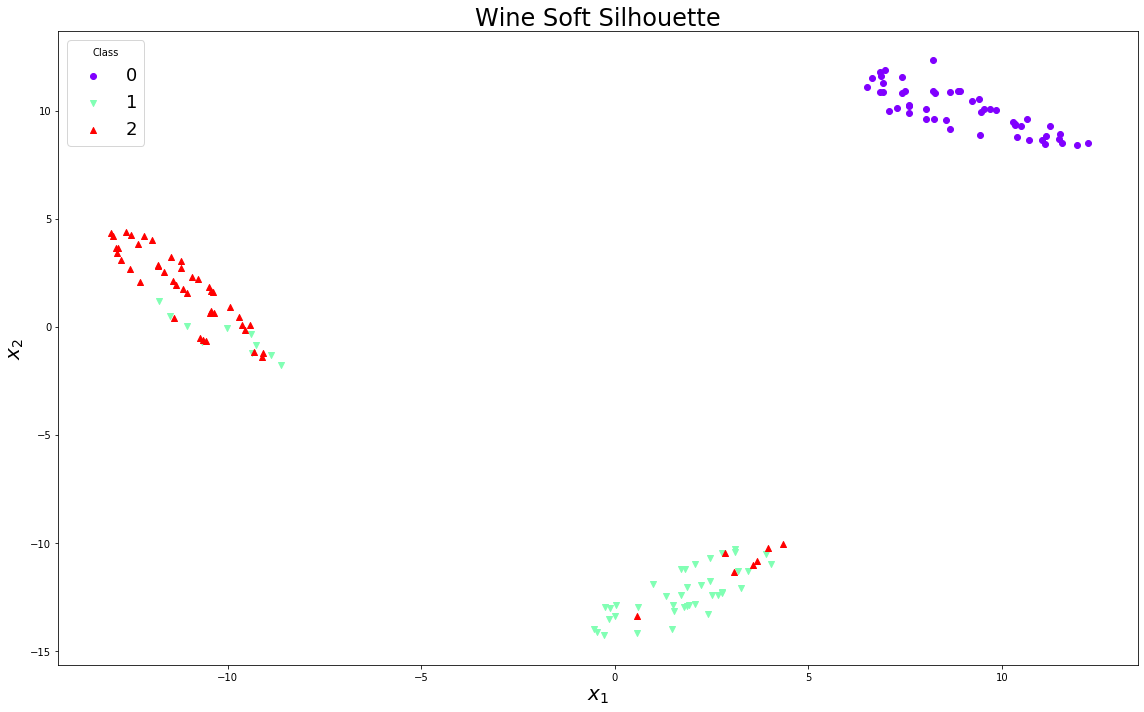

In [7]:
# Cluster with TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_enc = tsne.fit_transform(latent_data)
#tsne_enc = tsne.fit_transform(real_data)

# Color and marker for each true class
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
markers = matplotlib.markers.MarkerStyle.filled_markers

# Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16, 10))
for iclass in range(0, n_clusters):
    # Get indices for each class
    idxs = real_labels==iclass
    # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0], tsne_enc[idxs, 1],
               marker=markers[iclass], c=colors[iclass].reshape(1,-1),
               edgecolor=None, label=r'$%i$'%iclass)
    
figname="Wine Soft Silhouette"
ax.set_title(figname, fontsize=24)
ax.set_xlabel("$x_{1}$", fontsize=20)
ax.set_ylabel("$x_{2}$", fontsize=20)
plt.legend(title="Class", loc='best', numpoints=1, fontsize=18)
plt.tight_layout()
plt.show()
#fig.savefig(figname, facecolor='w')